## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

## Import libraries and load the dataset

In [1]:
# Import libraries used throughout the notebook
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from scipy.sparse import hstack

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.backend import clear_session

from imblearn.under_sampling import RandomUnderSampler

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
2023-01-08 09:29:50.518008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-08 09:29:50.710175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-08 09:29:50.710189: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

In [2]:
# Load the dataset
df = pd.read_csv('../data/train.csv')

#### Note
Since there was no designated test dataset for this project, we will use only the `train.csv` file - we will split it into train and test datasets using `Scikit-Learn`

### Exploration

In [3]:
# Look at first 10 entries in the dataset
df.head(10)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   
8   8    17    18                    When do you use シ instead of し?   
9   9    19    20  Motorola (company): Can I hack my Charter Moto...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1  
8              When do you use "&" instead of "and"?             0  
9  How do I hack Motorola DCX3400 for free internet?             0

In [4]:
# Check shape
df.shape

(404290, 6)

In [5]:
# Check for missing values
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
# What pairs have missing values? 
df[df.isna().any(axis=1)]

id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0

In [7]:
# Since those pairs are missing a question, we just drop them and reset index to account for removed rows
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Drop redundant 'id' column, save target to y variable
df.drop('id', axis=1, inplace=True)
y = df['is_duplicate']

In [8]:
# Look at questions labeled as duplicates
df[df['is_duplicate'] == 1]

qid1    qid2                                          question1  \
5           11      12  Astrology: I am a Capricorn Sun Cap moon and c...   
7           15      16                     How can I be a good geologist?   
11          23      24        How do I read and find my YouTube comments?   
12          25      26               What can make Physics easy to learn?   
13          27      28        What was your first sexual experience like?   
...        ...     ...                                                ...   
404277  537922  537923  What are some outfit ideas to wear to a frat p...   
404278   99131   81495  Why is Manaphy childish in Pokémon Ranger and ...   
404279    1931   16773        How does a long distance relationship work?   
404281  537926  537927         What does Jainism say about homosexuality?   
404283   18840  155606          Do you believe there is life after death?   

                                                question2  is_duplicate  
5       I'm a triple Capricorn (Sun, Moon and ascendan...             1  
7               What should I do to be a great geologist?             1  
11                 How can I see all my Youtube comments?             1  
12                How can you make physics easy to learn?             1  
13                 What was your first sexual experience?             1  
...                                                   ...           ...  
404277  What are some outfit ideas wear to a frat them...             1  
404278  Why is Manaphy annoying in Pokemon ranger and ...             1  
404279    How are long distance relationships maintained?             1  
404281  What does Jainism say about Gays and Homosexua...             1  
404283         Is it true that there is life after death?             1  

[149263 rows x 5 columns]

In [9]:
# What about non-duplicates?
df[df['is_duplicate'] == 0]

qid1    qid2                                          question1  \
0            1       2  What is the step by step guide to invest in sh...   
1            3       4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2            5       6  How can I increase the speed of my internet co...   
3            7       8  Why am I mentally very lonely? How can I solve...   
4            9      10  Which one dissolve in water quikly sugar, salt...   
...        ...     ...                                                ...   
404280  537924  537925  What do you think of the removal of the MagSaf...   
404282  433578  379845  How many keywords are there in the Racket prog...   
404284  537928  537929                                  What is one coin?   
404285  537930  537931  What is the approx annual cost of living while...   
404286  537932  537933              What is like to have sex with cousin?   

                                                question2  is_duplicate  
0       What is the step by step guide to invest in sh...             0  
1       What would happen if the Indian government sto...             0  
2       How can Internet speed be increased by hacking...             0  
3       Find the remainder when [math]23^{24}[/math] i...             0  
4                 Which fish would survive in salt water?             0  
...                                                   ...           ...  
404280  What will the CPU upgrade to the 2016 Apple Ma...             0  
404282  How many keywords are there in PERL Programmin...             0  
404284                                  What's this coin?             0  
404285  I am having little hairfall problem but I want...             0  
404286      What is it like to have sex with your cousin?             0  

[255024 rows x 5 columns]

In [10]:
# Check for sample imbalance
df['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

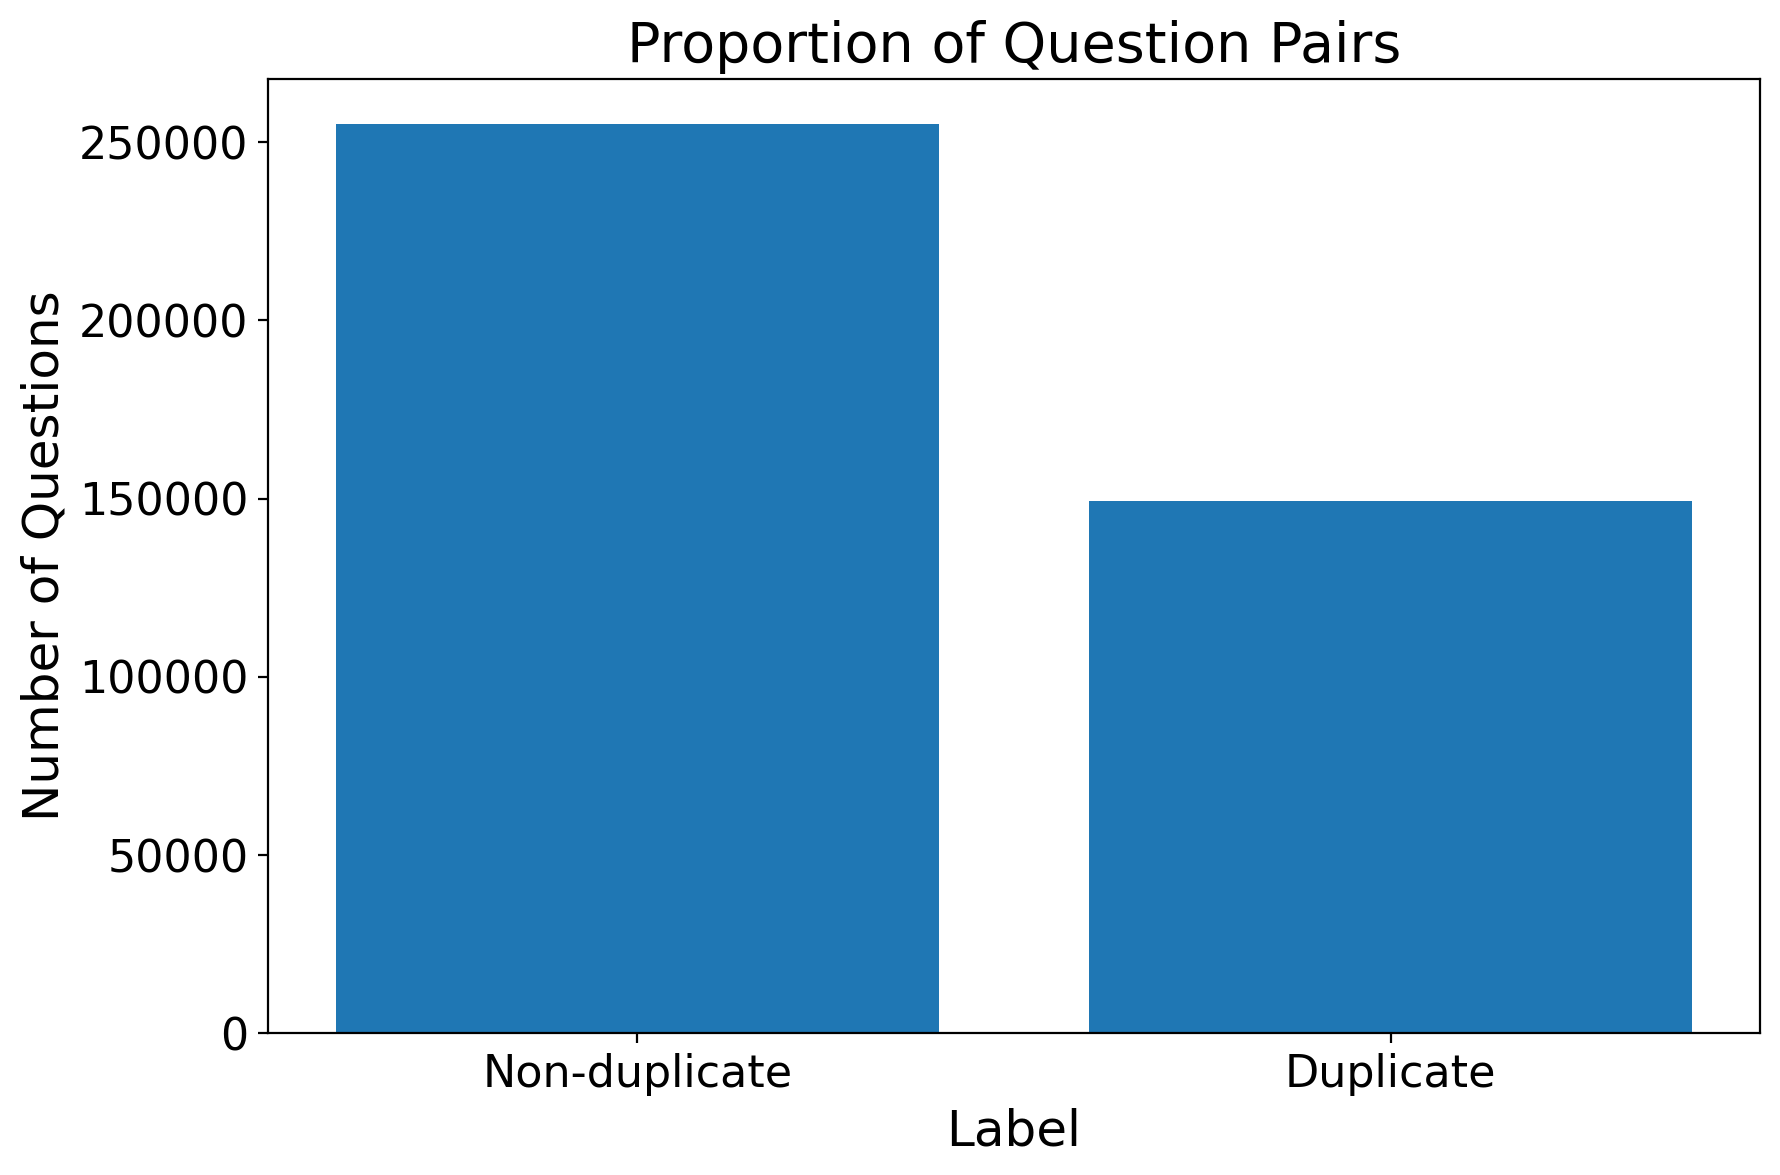

In [11]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(9,6))

# create bar chart
fig = plt.bar(x=['Non-duplicate', 'Duplicate'], height=df['is_duplicate'].value_counts())

# customize bar chart
ax.set_xticks([0, 1])
ax.set_title('Proportion of Question Pairs', fontsize=20)
ax.set_ylabel('Number of Questions', fontsize=18)
ax.set_xlabel('Label', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)

# Save and show plot
plt.tight_layout()
#plt.savefig('../saves/duplicates.png')
plt.show()

In [12]:
# Check data types in each column
df.dtypes

qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [13]:
# Create columns with character length 
df['q1_char_length'] = df['question1'].str.len()
df['q2_char_length'] = df['question2'].str.len()

In [14]:
# Check the mean character length
df[['q1_char_length', 'q2_char_length']].mean()

q1_char_length    59.536997
q2_char_length    60.108507
dtype: float64

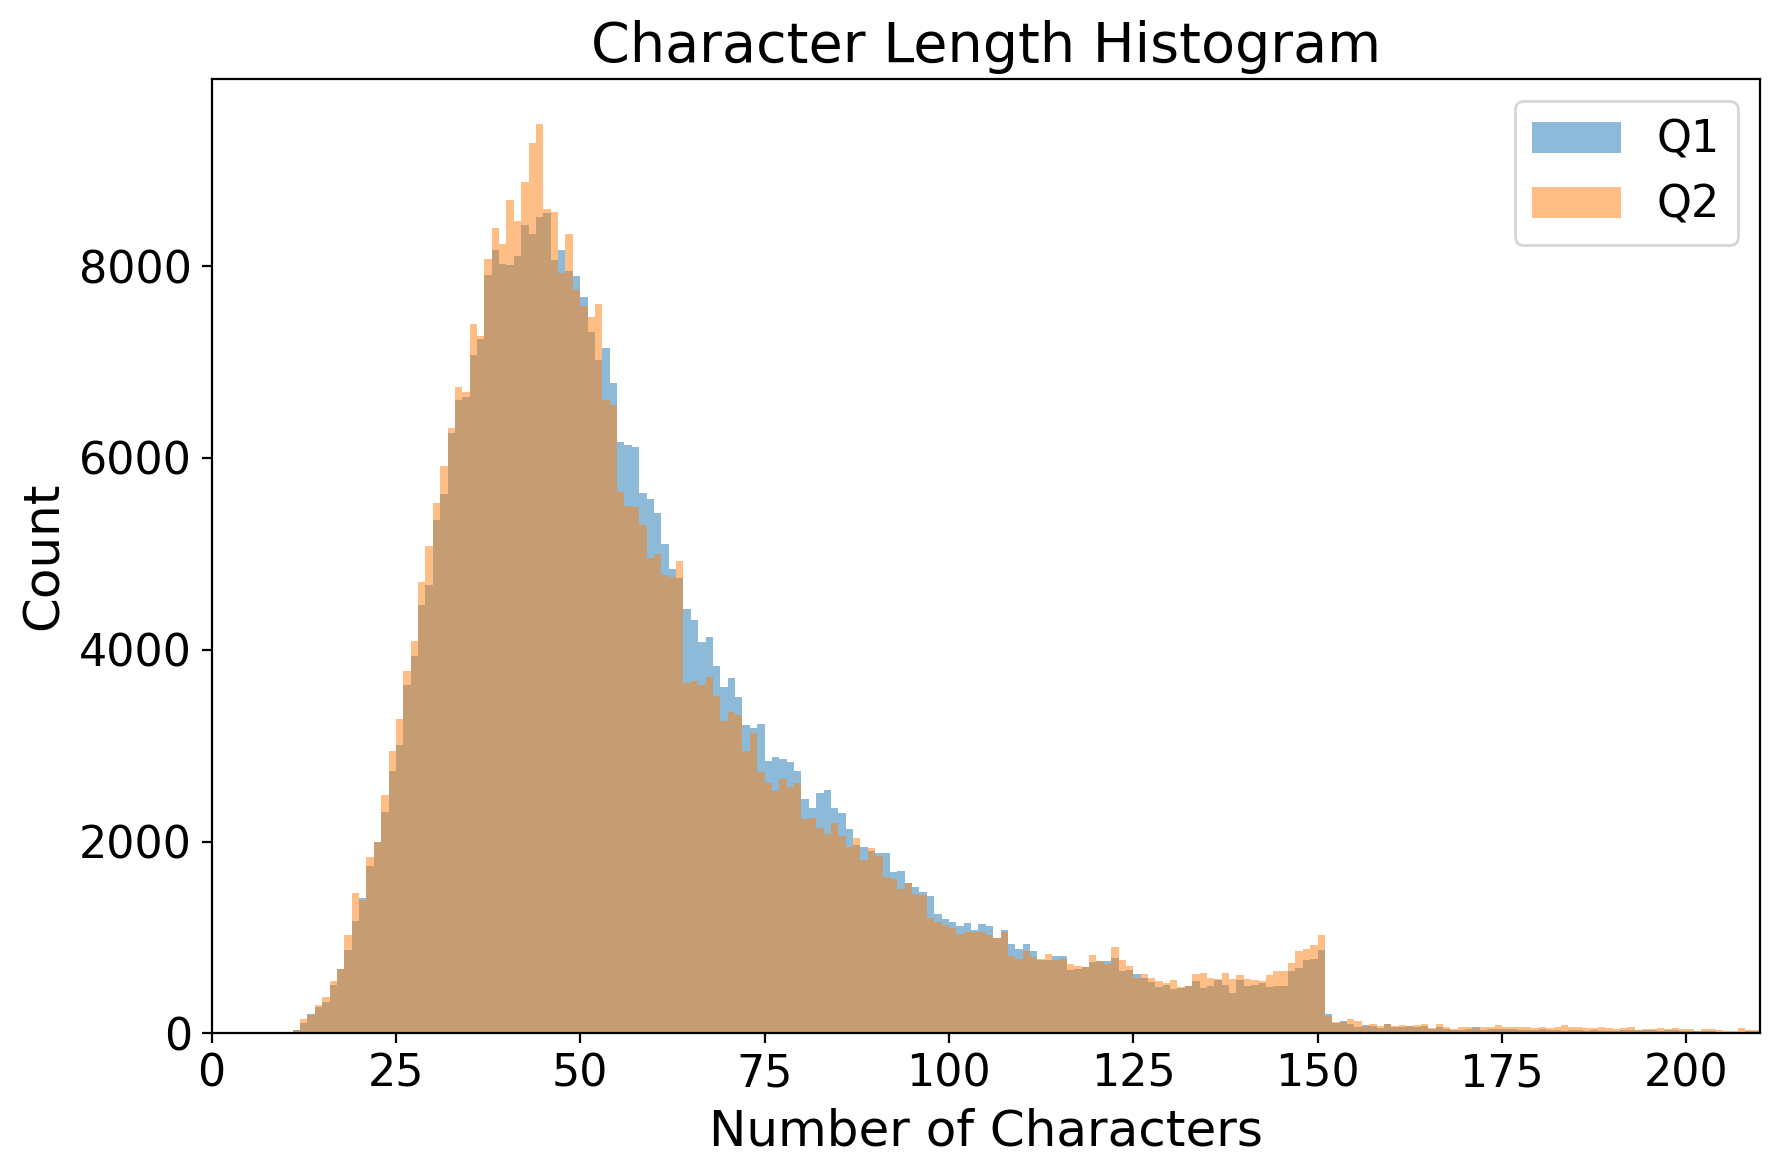

In [15]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(9,6))

# create bar chart
plt.hist(df['q1_char_length'], bins=250, alpha=0.5, range=[0, 250], label='Q1')
plt.hist(df['q2_char_length'], bins=250, alpha=0.5, range=[0, 250], label='Q2')

# customize bar chart
ax.set_title('Character Length Histogram', fontsize=20)
ax.set_ylabel('Count', fontsize=18)
ax.set_xlabel('Number of Characters', fontsize=18)
ax.set_xlim([0, 210])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16)

# Save and show plot
plt.tight_layout()
#plt.savefig('../saves/char_length.png')
plt.show()

In [16]:
# Drop off after 150 characters - possibly size limit at Quora?

In [17]:
# Checking the amount of unique and repeated questions
qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537929
Number of questions getting repeated 111778


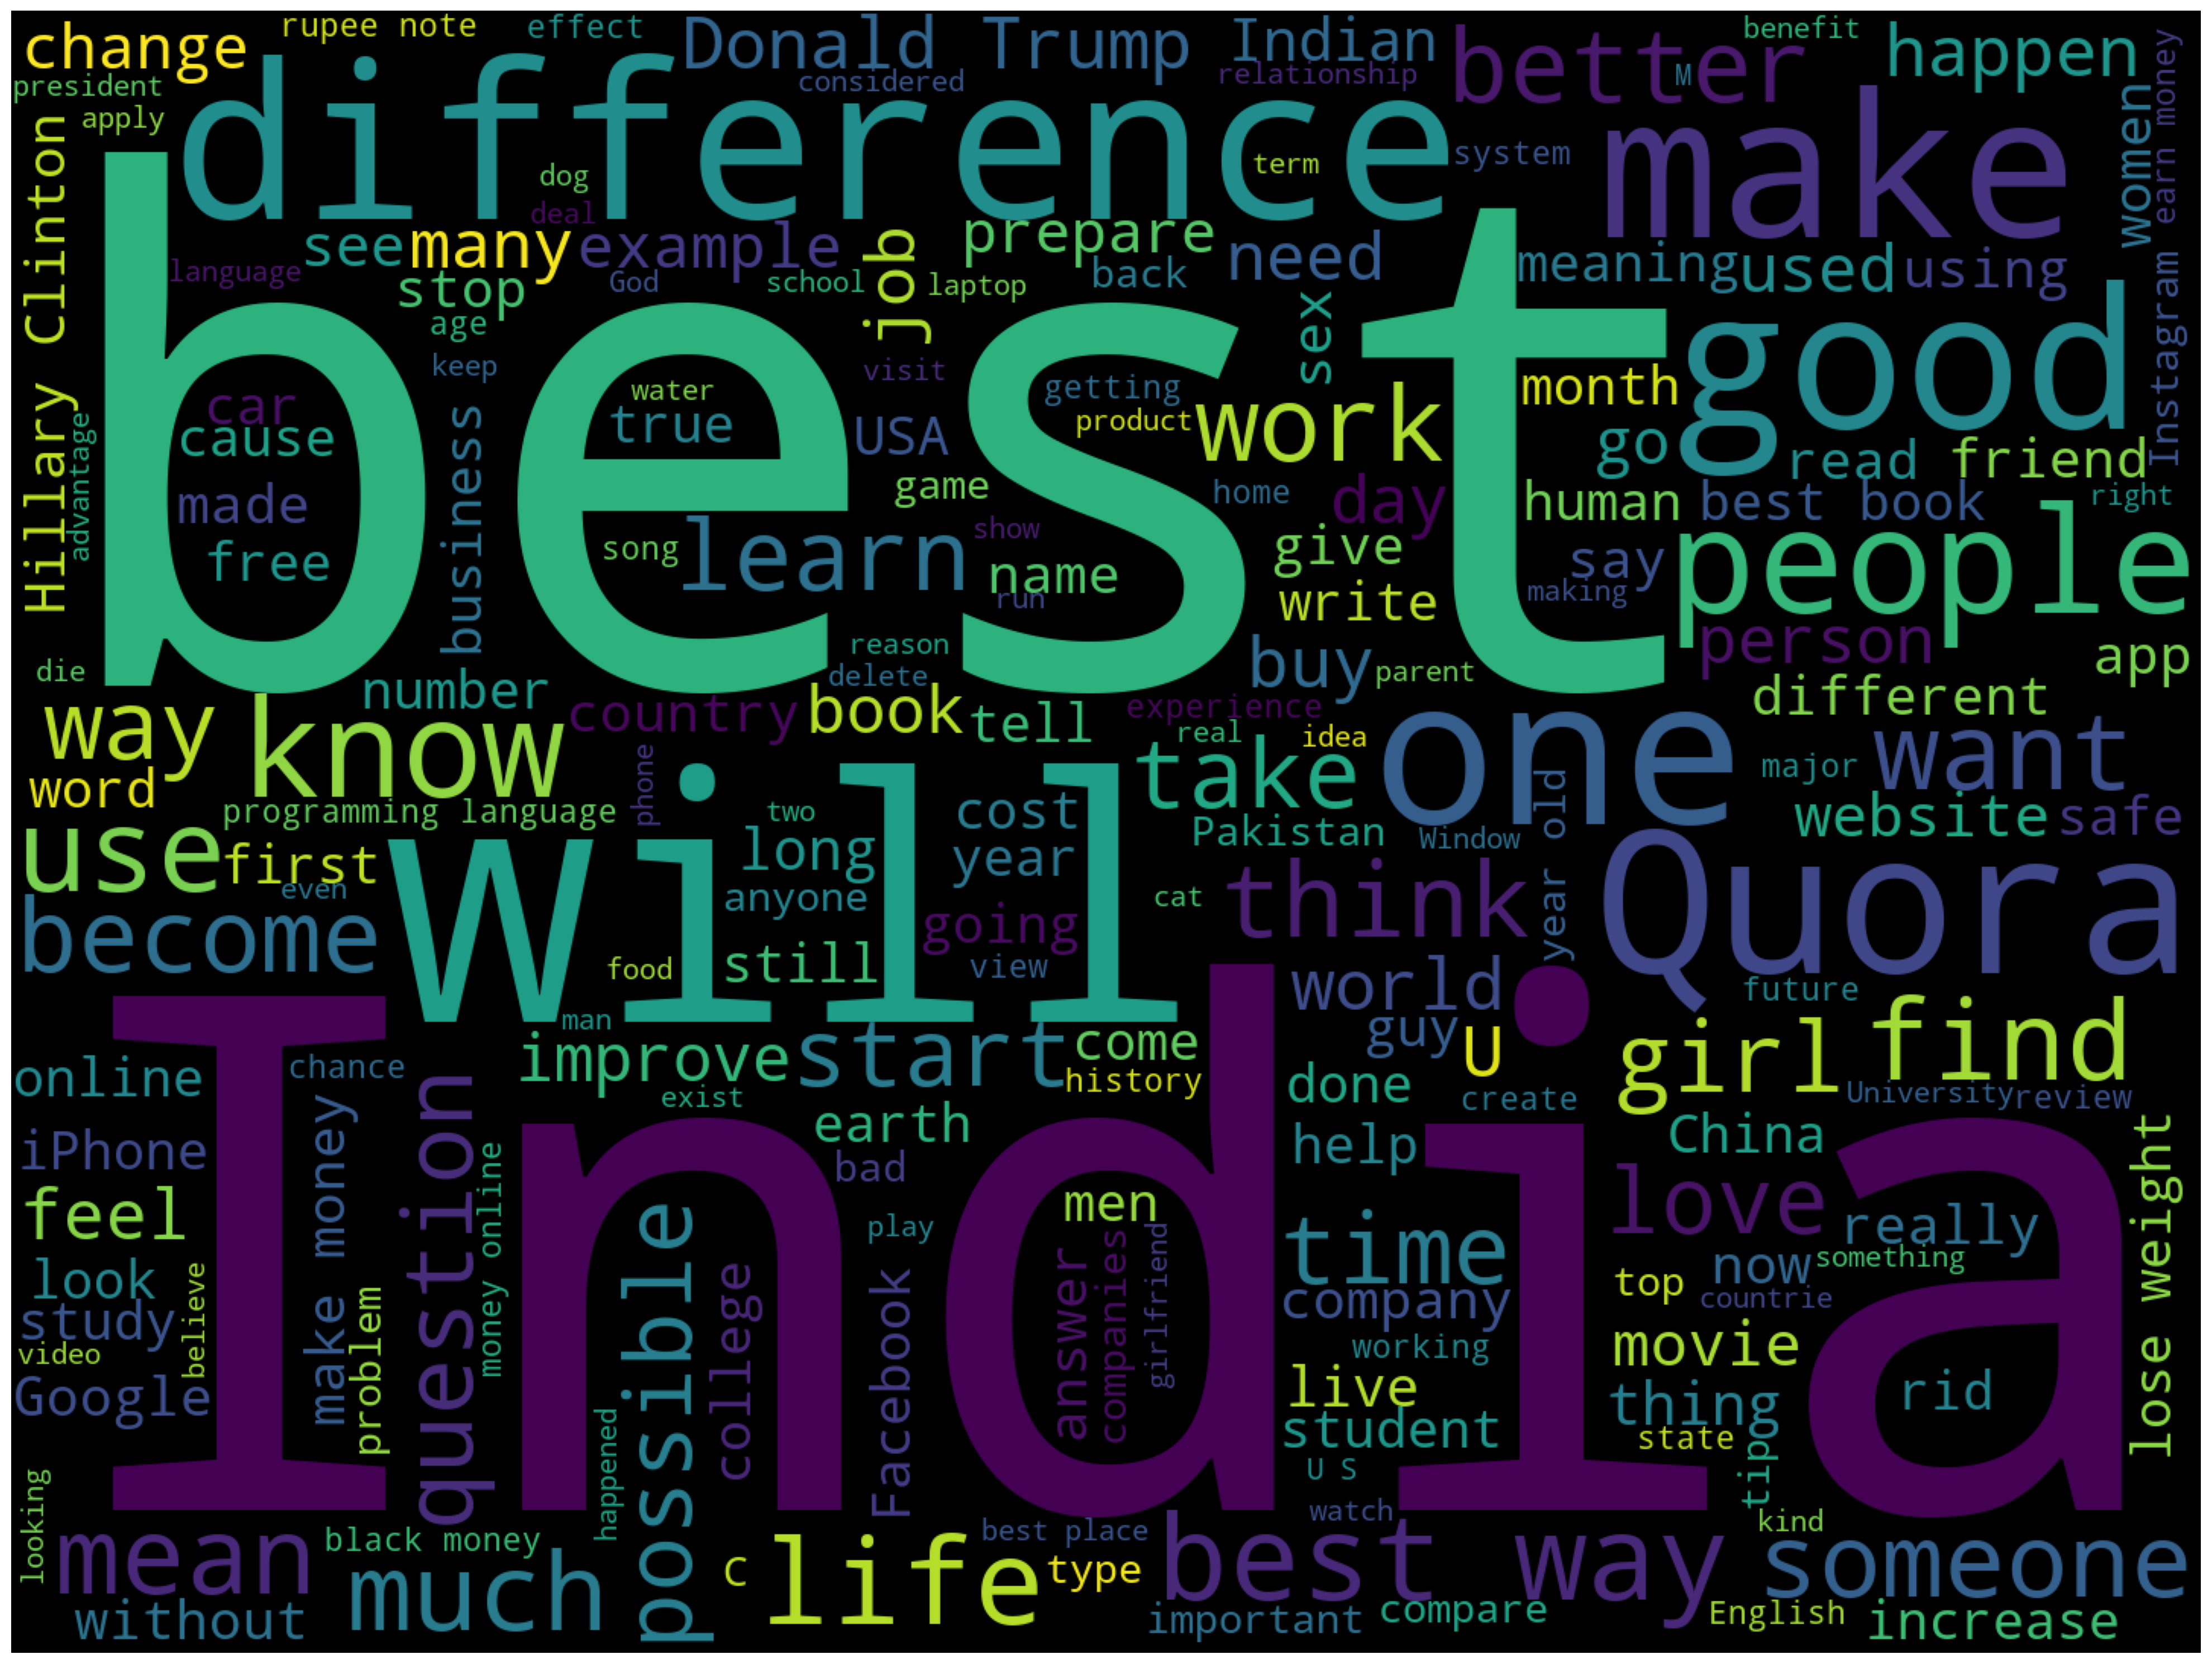

In [18]:
# Let's look at the most frequent words using wordcloud
cloud_q1 = WordCloud(width=1440, height=1080).generate(" ".join(df['question1'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud_q1)
plt.axis('off')
plt.tight_layout()
#plt.savefig('../saves/cloud_q1.png')

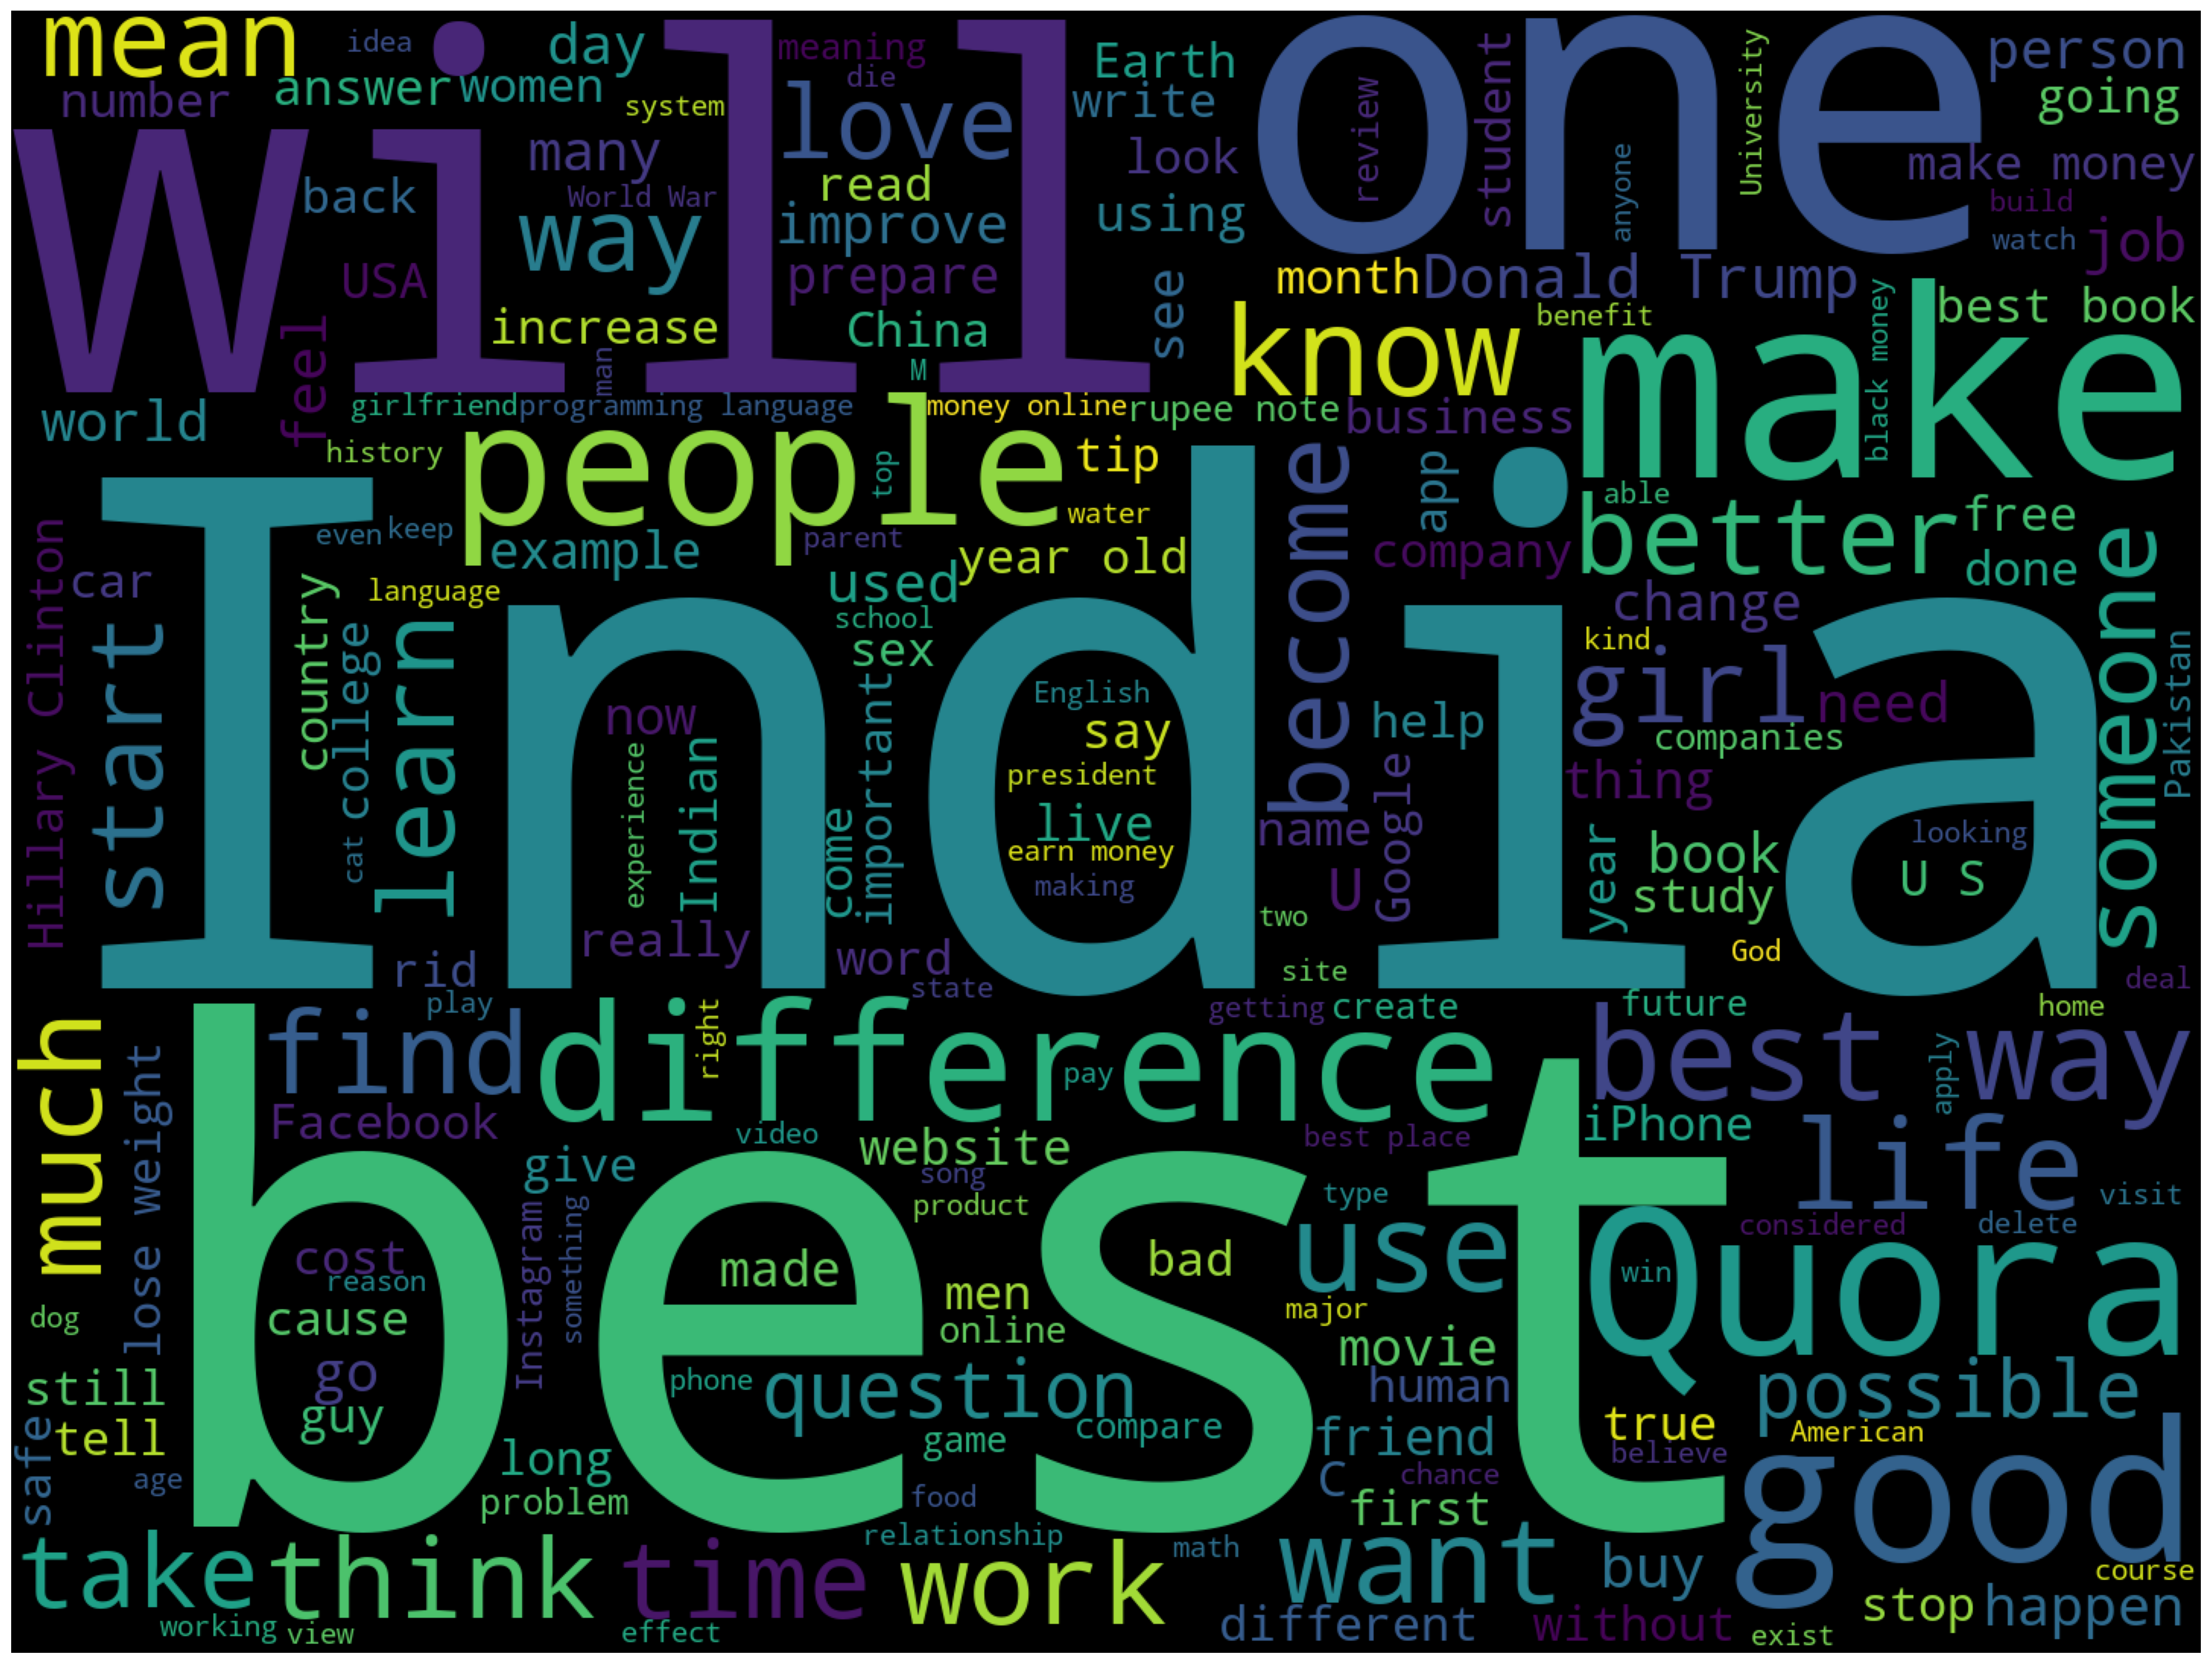

In [19]:
cloud_q2 = WordCloud(width=1440, height=1080).generate(" ".join(df['question2'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud_q2)
plt.axis('off')
plt.tight_layout()
#plt.savefig('../saves/cloud_q2.png')

In [20]:
#len(df['question1'].tolist() + df['question2'].tolist())

## Cleaning
When work with natural language, these are some of the steps we need to take prior to building the model: 
- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [21]:
def preprocess(text):
    """
    Function that takes in a raw string and applies a series of transformations in sequence:
        - Lower case
        - Tokenization
        - Stopword removal (Engligh only)
        - Punctuation removal 
        - Lemmatization
        
    Args:
        text: string-type values
    
    Returns: 
        Processed text
    """
    # make lower case 
    text = text.lower()
    
    # tokenize
    text = word_tokenize(text)
    
    # remove stopwords
    stoppers = stopwords.words('english')
    text = [word for word in text if word not in stoppers]
    
    # remove punctuation
    text = [word for word in text if word.isalpha()]
    
    # lemmatize
    lemm = WordNetLemmatizer()
    text = [lemm.lemmatize(words) for words in text]
    
    return text

In [22]:
df['q1_token'] = df['question1'].apply(preprocess)
df['q2_token'] = df['question2'].apply(preprocess)

In [23]:
df.head()

qid1  qid2                                          question1  \
0     1     2  What is the step by step guide to invest in sh...   
1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2     5     6  How can I increase the speed of my internet co...   
3     7     8  Why am I mentally very lonely? How can I solve...   
4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   
3  Find the remainder when [math]23^{24}[/math] i...             0   
4            Which fish would survive in salt water?             0   

   q1_char_length  q2_char_length  \
0              66              57   
1              51              88   
2              73              59   
3              50              65   
4              76              39   

                                            q1_token  \
0  [step, step, guide, invest, share, market, india]   
1                         [story, kohinoor, diamond]   
2  [increase, speed, internet, connection, using,...   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                            q2_token  
0         [step, step, guide, invest, share, market]  
1  [would, happen, indian, government, stole, koh...  
2         [internet, speed, increased, hacking, dns]  
3                   [find, remainder, math, divided]  
4                [fish, would, survive, salt, water]

## Feature Engineering

Now that the text has been processed, we can start playing with the features that will be used in our duplicate verifier. Here are different approaches that could be taken:

- tf-idf
- word2vec
- word count
- number of the same words in both questions

In [24]:
# Build baseline model: word count
df['q1_n_words'] = df['q1_token'].apply(len)
df['q2_n_words'] = df['q2_token'].apply(len)

In [25]:
df.head()

qid1  qid2                                          question1  \
0     1     2  What is the step by step guide to invest in sh...   
1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2     5     6  How can I increase the speed of my internet co...   
3     7     8  Why am I mentally very lonely? How can I solve...   
4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   
3  Find the remainder when [math]23^{24}[/math] i...             0   
4            Which fish would survive in salt water?             0   

   q1_char_length  q2_char_length  \
0              66              57   
1              51              88   
2              73              59   
3              50              65   
4              76              39   

                                            q1_token  \
0  [step, step, guide, invest, share, market, india]   
1                         [story, kohinoor, diamond]   
2  [increase, speed, internet, connection, using,...   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                            q2_token  q1_n_words  q2_n_words  
0         [step, step, guide, invest, share, market]           7           6  
1  [would, happen, indian, government, stole, koh...           3           8  
2         [internet, speed, increased, hacking, dns]           6           5  
3                   [find, remainder, math, divided]           3           4  
4                [fish, would, survive, salt, water]          10           5

In [26]:
# Let's also create new columns with the processed (clean) text for q1 and q2 
df['q1_clean'] = df['q1_token'].apply(lambda x: ' '.join(x))
df['q2_clean'] = df['q2_token'].apply(lambda x: ' '.join(x))

In [27]:
df.head()

qid1  qid2                                          question1  \
0     1     2  What is the step by step guide to invest in sh...   
1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2     5     6  How can I increase the speed of my internet co...   
3     7     8  Why am I mentally very lonely? How can I solve...   
4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   
3  Find the remainder when [math]23^{24}[/math] i...             0   
4            Which fish would survive in salt water?             0   

   q1_char_length  q2_char_length  \
0              66              57   
1              51              88   
2              73              59   
3              50              65   
4              76              39   

                                            q1_token  \
0  [step, step, guide, invest, share, market, india]   
1                         [story, kohinoor, diamond]   
2  [increase, speed, internet, connection, using,...   
3                          [mentally, lonely, solve]   
4  [one, dissolve, water, quikly, sugar, salt, me...   

                                            q2_token  q1_n_words  q2_n_words  \
0         [step, step, guide, invest, share, market]           7           6   
1  [would, happen, indian, government, stole, koh...           3           8   
2         [internet, speed, increased, hacking, dns]           6           5   
3                   [find, remainder, math, divided]           3           4   
4                [fish, would, survive, salt, water]          10           5   

                                            q1_clean  \
0          step step guide invest share market india   
1                             story kohinoor diamond   
2       increase speed internet connection using vpn   
3                              mentally lonely solve   
4  one dissolve water quikly sugar salt methane c...   

                                            q2_clean  
0                step step guide invest share market  
1  would happen indian government stole kohinoor ...  
2               internet speed increased hacking dns  
3                        find remainder math divided  
4                      fish would survive salt water

In [28]:
# Using tf-idf
vectorizer = TfidfVectorizer()

In [29]:
# Run tf-idf on each question
q1_tfidf = vectorizer.fit_transform(df['q1_clean'])
#vocab1 = vectorizer.vocabulary_
q2_tfidf = vectorizer.fit_transform(df['q2_clean'])
#vocab2 = vectorizer.vocabulary_

In [30]:
#vocab1_keys = list(vocab1.keys())

In [31]:
#vocab1_vals = list(vocab1.values())

In [32]:
#idx_sorted = np.argsort(np.array(vocab1_vals))

In [33]:
#[vocab1_keys[i] for i in idx_sorted]

In [34]:
q_tfidf = hstack((q1_tfidf, q2_tfidf))

In [35]:
q_tfidf.shape

(404287, 104703)

In [36]:
# Matrix is too large, let's try using SVD to reduce dimensionality
# Instantiate it 
svd = TruncatedSVD(n_components=200)

# Fit to our matrix
q_svd = svd.fit_transform(q_tfidf)

In [37]:
# Check the shape
q_svd.shape

(404287, 200)

In [38]:
# Need to calculate similarity between q1_tfidf and q2_tfidf
#from numpy import dot
#from numpy.linalg import norm

#cos_sim = (q1_tfidf @ q2_tfidf.T) / (norm(q1_tfidf)*norm(q2_tfidf))

In [39]:
#def cosine_sim(q1, q2):
#    try:
#        tfidf = vectorizer.fit_transform([q1, q2])
        #print(text1)
        #print(text2)
#    except Exception:
#        print(text1)
#        print(text2)
    
#    return ((tfidf * tfidf.T).A)[0,1]

In [40]:
#my_list = []

#for index, row in df.iloc[0:100].iterrows():
#    cosine_ = cosine_sim(row['q1_clean'], row['q2_clean'])
#    my_list.append(cosine_)

In [41]:
#my_list

## Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [42]:
# Check the df shape as a reminder
df.head(3)

qid1  qid2                                          question1  \
0     1     2  What is the step by step guide to invest in sh...   
1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2     5     6  How can I increase the speed of my internet co...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   

   q1_char_length  q2_char_length  \
0              66              57   
1              51              88   
2              73              59   

                                            q1_token  \
0  [step, step, guide, invest, share, market, india]   
1                         [story, kohinoor, diamond]   
2  [increase, speed, internet, connection, using,...   

                                            q2_token  q1_n_words  q2_n_words  \
0         [step, step, guide, invest, share, market]           7           6   
1  [would, happen, indian, government, stole, koh...           3           8   
2         [internet, speed, increased, hacking, dns]           6           5   

                                       q1_clean  \
0     step step guide invest share market india   
1                        story kohinoor diamond   
2  increase speed internet connection using vpn   

                                            q2_clean  
0                step step guide invest share market  
1  would happen indian government stole kohinoor ...  
2               internet speed increased hacking dns

### Logistic Regression + Word Counts

This will be used as our baseline model as it is quite simple - we are only checking if questions are the same based on the number of words (tokens), and using a linear model to make the decision

In [43]:
# Select our target and features
X = df[['q1_n_words', 'q2_n_words']]
y = df['is_duplicate']

In [44]:
# split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
print(X_train.shape)
print(X_test.shape)

(283000, 2)
(121287, 2)


In [46]:
# Instantiate logistic regression classifier
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

In [47]:
# Check accuracy
logreg.score(X_test, y_test)

0.6213444144879501

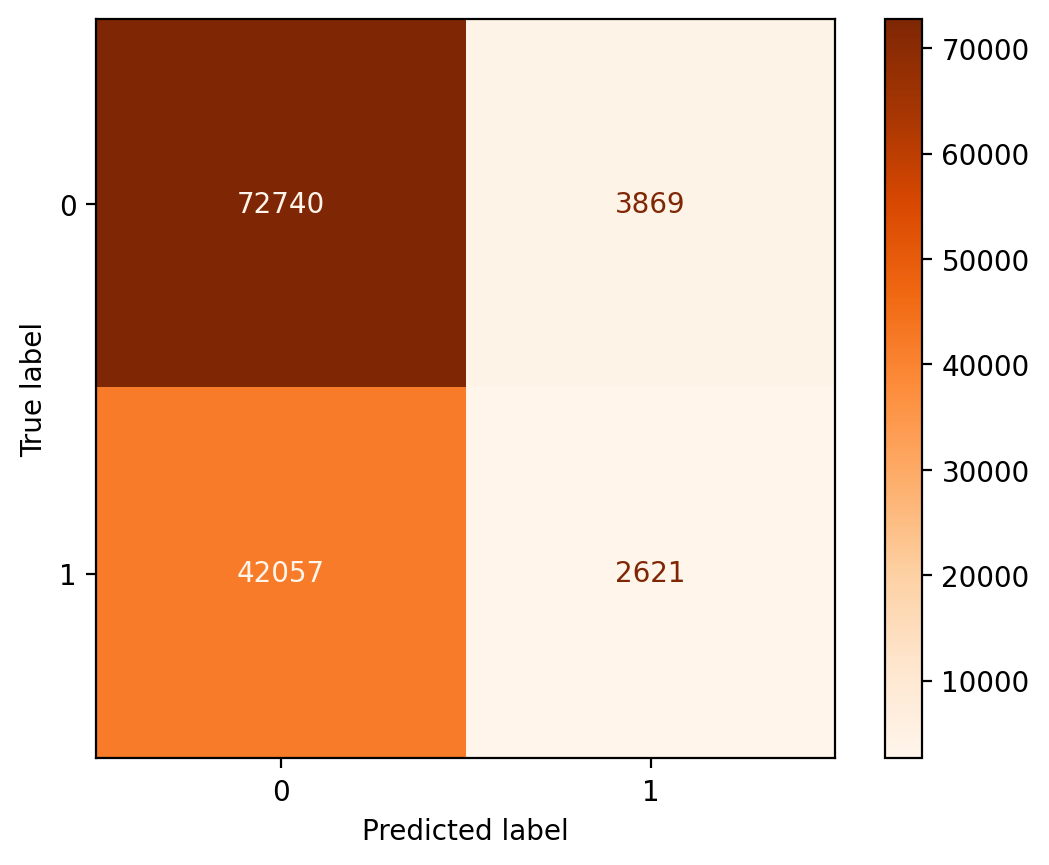

In [48]:
# Check confusion matrix as an evaluation tool (true positives and negatives, false positives and negatives)
matrix = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Oranges')
#matrix.plot()
#plt.savefig('../saves/confusion_matrix_LRWC.png')
plt.show()

We can see that the baseline model performs well with question pairs that are not duplicates, but poorly when it comes to duplicate pairs - this is expected since the dataset is imbalanced. 

### XGBoost + Word Counts

XGBoost Classifier is a more complex algorithm that can be used for classifications problems such as this. 

In [49]:
# Instantiate XGB Classifier
xgb = XGBClassifier()

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Evaluate
xgb.score(X_test, y_test)

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[09:37:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6417093340588851

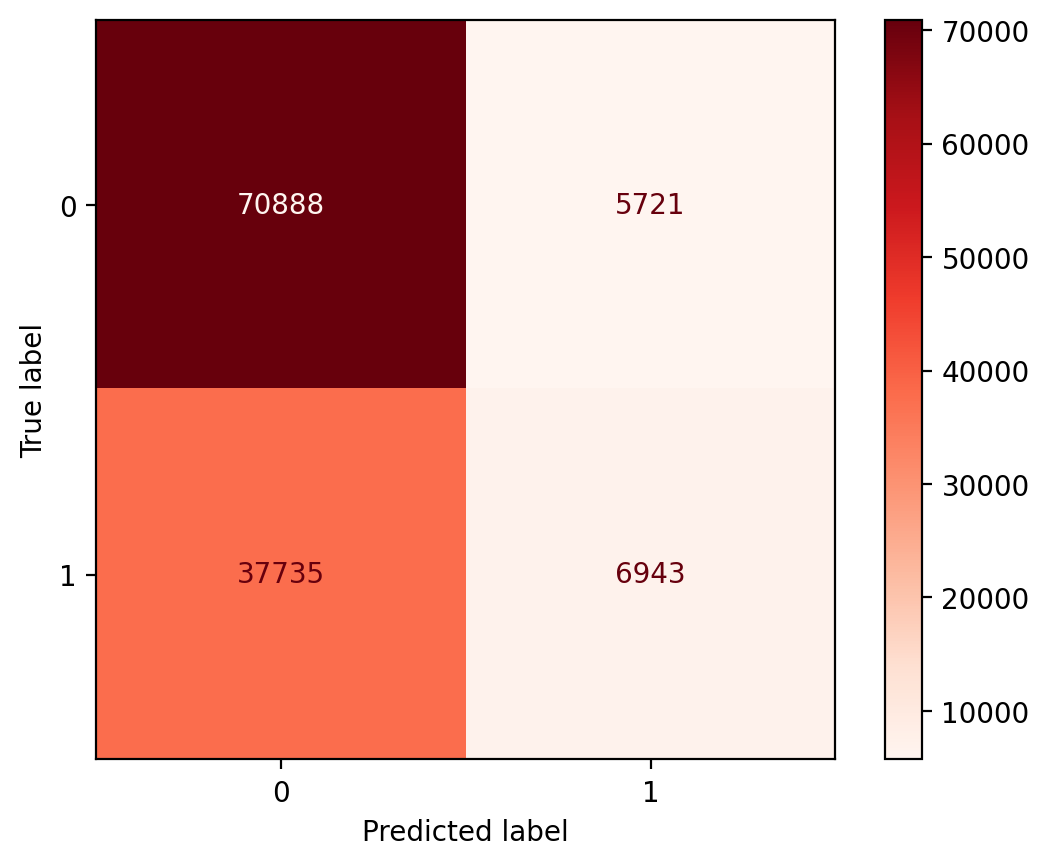

In [50]:
# Check the confusion matrix for this model 
matrix_xgb = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds')
#matrix.plot()
#plt.savefig('../saves/confusion_matrix_XCWC.png')
plt.show()

We can see that the XGBClassifier + Word Count model performs better in terms of the positive class and worse for the negative class. 

### Logistic Regression + TFIDF/SVD 

In [51]:
# This time we will work with the q_svd dataset
X_train, X_test, y_train, y_test = train_test_split(q_svd, y, test_size=0.3, random_state=42)

In [52]:
print(X_train.shape)
print(X_test.shape)

(283000, 200)
(121287, 200)


In [53]:
# Instantiate Classifier
logreg = LogisticRegression()

# Train the model
logreg.fit(X_train, y_train)

# Predict
y_pred = logreg.predict(X_test)

# Check accuracy
logreg.score(X_test, y_test)

0.709523691739428

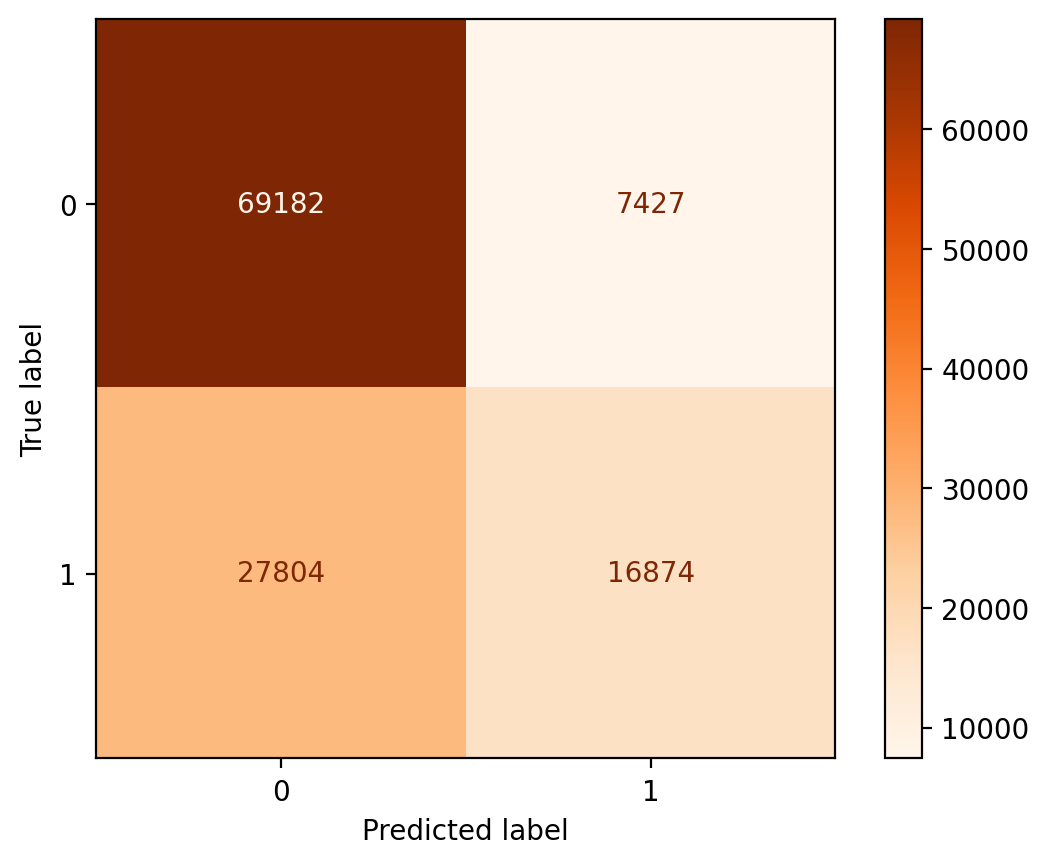

In [54]:
# Model evaluation
matrix_lr_tfidf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Oranges')
#matrix.plot()
#plt.savefig('../saves/confusion_matrix_LRTF.png')
plt.show()

This model performs even for questions that are duplicates without a significant performance loss when it comes to non duplicates.

### XGBoost + TFIDF/SVD 

In [55]:
# Instantiate
xgb = XGBClassifier()

# Train the model
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)

# Check accuracy
xgb.score(X_test, y_test)

/home/eduardo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:52] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7522075737713028

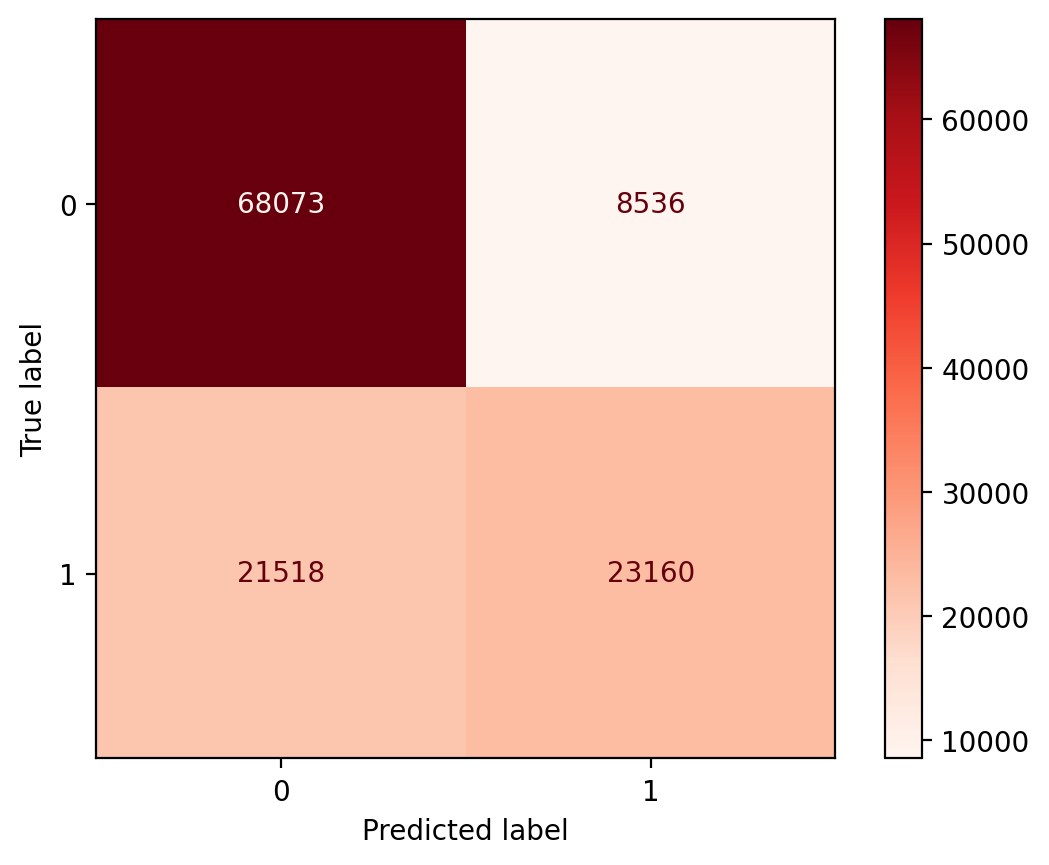

In [56]:
# Check the confusion matrix for this model 
matrix_xgb_tfidf = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds')
#matrix.plot()
#plt.savefig('../saves/confusion_matrix_XGTF.png')
plt.show()

Compared to the previous XGBClassifier + Word Count model, we have some loss in accuracy when looking at non duplicate pairs, but the model performs significantly better for duplicate pairs (more true positives than false negatives)!

### LSTM
In this section, let's use a different method just to practice working with different tools. Here, we will use sklearn's `CountVectorizer`

In [57]:
df.head(3)

qid1  qid2                                          question1  \
0     1     2  What is the step by step guide to invest in sh...   
1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2     5     6  How can I increase the speed of my internet co...   

                                           question2  is_duplicate  \
0  What is the step by step guide to invest in sh...             0   
1  What would happen if the Indian government sto...             0   
2  How can Internet speed be increased by hacking...             0   

   q1_char_length  q2_char_length  \
0              66              57   
1              51              88   
2              73              59   

                                            q1_token  \
0  [step, step, guide, invest, share, market, india]   
1                         [story, kohinoor, diamond]   
2  [increase, speed, internet, connection, using,...   

                                            q2_token  q1_n_words  q2_n_words  \
0         [step, step, guide, invest, share, market]           7           6   
1  [would, happen, indian, government, stole, koh...           3           8   
2         [internet, speed, increased, hacking, dns]           6           5   

                                       q1_clean  \
0     step step guide invest share market india   
1                        story kohinoor diamond   
2  increase speed internet connection using vpn   

                                            q2_clean  
0                step step guide invest share market  
1  would happen indian government stole kohinoor ...  
2               internet speed increased hacking dns

In [58]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

In [60]:
# Merge texts - we will need to take a slice since the dataset is very large
questions = np.array(list(df['q1_clean'][:80000]) + list(df['q2_clean'][:80000]))

# Instantiate count vectorizer
cv = CountVectorizer(max_features=1500)

# Create vectors for each word, and then split the result
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [62]:
# Create a df for each vector matrix and combine them
vect_df1 = pd.DataFrame(q1_arr, index= df[:80000].index)
vect_df2 = pd.DataFrame(q2_arr, index= df[:80000].index)
vect_df = pd.concat([vect_df1, vect_df2], axis=1)
vect_df.shape

(80000, 3000)

In [63]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(vect_df, y[:80000], test_size=0.25, random_state=42)

In [64]:
print(X_train.shape)
print(y_train.shape)

(60000, 3000)
(60000,)


In [65]:
# Set input_dim to match no. of feats
input_dim = X_train.shape[1]

# Create Model
model = Sequential()

# Add layers
model.add(Dense(10, input_dim=input_dim, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-01-08 09:43:09.752289: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-08 09:43:09.752431: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-08 09:43:09.752446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (edu-desktop): /proc/driver/nvidia/version does not exist
2023-01-08 09:43:09.752785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
# Compile and check overview
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30010     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 30,021
Trainable params: 30,021
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Train the model 
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5833 - accuracy: 0.6994 - val_loss: 0.5645 - val_accuracy: 0.7160
Epoch 2/10
1875/1875 [==============================] - 2s 937us/step - loss: 0.5459 - accuracy: 0.7280 - val_loss: 0.5630 - val_accuracy: 0.7178
Epoch 3/10
1875/1875 [==============================] - 2s 942us/step - loss: 0.5336 - accuracy: 0.7354 - val_loss: 0.5638 - val_accuracy: 0.7157
Epoch 4/10
1875/1875 [==============================] - 2s 945us/step - loss: 0.5241 - accuracy: 0.7420 - val_loss: 0.5649 - val_accuracy: 0.7186
Epoch 5/10
1875/1875 [==============================] - 2s 941us/step - loss: 0.5154 - accuracy: 0.7465 - val_loss: 0.5645 - val_accuracy: 0.7196
Epoch 6/10
1875/1875 [==============================] - 2s 957us/step - loss: 0.5059 - accuracy: 0.7528 - val_loss: 0.5680 - val_accuracy: 0.7193
Epoch 7/10
1875/1875 [==============================] - 2s 939us/step - loss: 0.4964 - accuracy: 0.7589 - val_loss: 0.5706 - v

In [68]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8022
Testing Accuracy:  0.7206


The neural network model has an accuracy close to that of the XGBClassifier + TF-IDF model, even though we used a 'bag of words' approach to processing the data. This shows the power of neural networks, and with proper optimization this model will achieve even higher accuracy

In [30]:
clear_session()

### Using Keras Processing

How can i feed a list of words, or vocabulary, to the model? Perhaps I could use text vectorizer? Use raw questions or tokenized questions?

https://www.tensorflow.org/text/tutorials/text_classification_rnn#setup_input_pipeline

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization